In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
torch.__version__

'2.6.0a0+df5bbc09d1.nv24.12'

# MNIST数据集手写数字识别
## 数据集介绍
MNIST 包括6万张28x28的训练样本，1万张测试样本，都会对它”下手”几乎成为一个 “典范”，可以说它就是计算机视觉里面的Hello World。所以我们这里也会使用MNIST来进行实战。

首先我们定义一些超参数，并启用GPU加速。

In [3]:
# Hyperparameters
batch_sz=512
epochs=10 
lr=0.02

# Using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

Pytorch已经包含了MNIST的数据集，我们这里直接使用即可。 如果第一次执行会生成data文件夹，并且需要一些时间下载，如果以前下载过就不会再次下载了。

由于官方已经实现了dataset，所以这里可以直接使用DataLoader来对数据进行读取：

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=transform),
        batch_size=batch_sz, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transform),
        batch_size=batch_sz, shuffle=True)

In [6]:
len(train_loader.dataset), len(test_loader.dataset)

(60000, 10000)

## 数据集可视化

Jupyter可以借由一些API渲染二维图像。这里我们使用`matplotlib`的绘图功能，可以查看数据集的图像。

In [7]:
import matplotlib.pyplot as plt

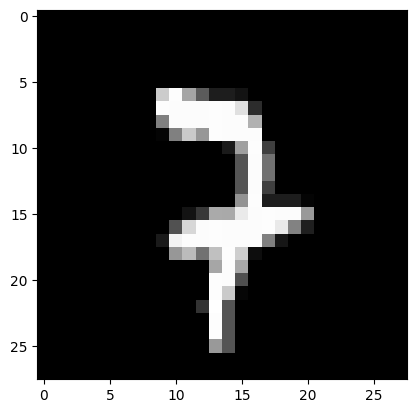

In [8]:
plt.imshow(test_loader.dataset.data[114].numpy(), cmap='gray')

In [9]:
test_loader.dataset.targets[114]

tensor(7)

## 网络设计

定义一个网络，网络包含两个卷积层，`conv1`和`conv2`，并且在卷积之后执行池化和`relu()`，然后紧接着两个全连接层作为输出，最后再加上一个全连接层输出10个维度，这10个维度被`log_softmax()`激活之后我们作为0-9的标识来确定识别出的是那个数字。


In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## 训练

我们使用Adam算法的优化器来训练模型。

In [11]:
model = Net().to(device)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

test_losses = []
accuracies = []

In [12]:
from tqdm import tqdm
trange = tqdm(range(epochs))
# Training loop
for epoch in trange:
    # Training
    model.train()
    train_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        trange.set_description(f'Loss: {loss.item():.5f}')
    
    # Testing
    model.eval()
    test_loss = 0
    correct = 0
    accuracy = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        
        test_loss /= len(test_loader.dataset)
        accuracy = (100. * correct / len(test_loader.dataset)).item()
        accuracies.append(accuracy)
        test_losses.append(test_loss)
        tqdm.write(f'Epoch: {epoch+1}/{epochs} Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    

Loss: 0.30105:  10%|█         | 1/10 [00:08<01:18,  8.68s/it]

Epoch: 1/10 Test set: Average loss: 0.1373, Accuracy: 95.61%


Loss: 0.26890:  20%|██        | 2/10 [00:17<01:08,  8.54s/it]

Epoch: 2/10 Test set: Average loss: 0.1037, Accuracy: 97.03%


Loss: 0.20611:  30%|███       | 3/10 [00:25<00:59,  8.47s/it]

Epoch: 3/10 Test set: Average loss: 0.1038, Accuracy: 97.10%


Loss: 0.26547:  40%|████      | 4/10 [00:34<00:50,  8.43s/it]

Epoch: 4/10 Test set: Average loss: 0.1012, Accuracy: 97.28%


Loss: 0.23135:  50%|█████     | 5/10 [00:42<00:42,  8.40s/it]

Epoch: 5/10 Test set: Average loss: 0.1030, Accuracy: 97.11%


Loss: 0.23168:  60%|██████    | 6/10 [00:50<00:33,  8.38s/it]

Epoch: 6/10 Test set: Average loss: 0.1037, Accuracy: 97.31%


Loss: 0.21782:  70%|███████   | 7/10 [00:59<00:25,  8.35s/it]

Epoch: 7/10 Test set: Average loss: 0.0872, Accuracy: 97.31%


Loss: 0.18446:  80%|████████  | 8/10 [01:07<00:16,  8.30s/it]

Epoch: 8/10 Test set: Average loss: 0.0811, Accuracy: 97.79%


Loss: 0.30415:  90%|█████████ | 9/10 [01:15<00:08,  8.26s/it]

Epoch: 9/10 Test set: Average loss: 0.1006, Accuracy: 97.41%


Loss: 0.10810: 100%|██████████| 10/10 [01:23<00:00,  8.34s/it]

Epoch: 10/10 Test set: Average loss: 0.0948, Accuracy: 97.45%


我们可以绘制图像以查看随着训练进行，准确度和损失函数的变化。我们可以修改网络结构以获得更好的性能、使用`tensorboard`等工具监视训练过程，不过这些就不是这份教程需要讲解的了。

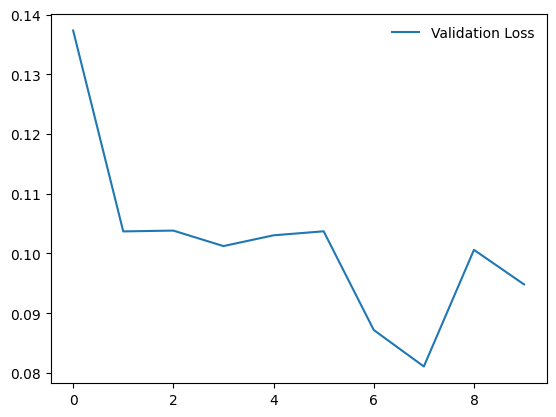

In [13]:
plt.plot(test_losses, label = 'Validation Loss')
plt.legend(frameon = False)

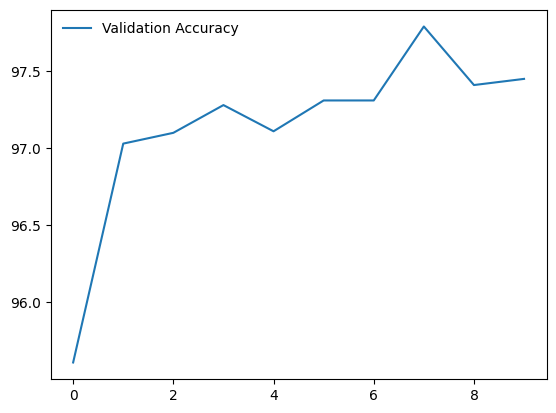

In [14]:
plt.plot(accuracies, label = 'Validation Accuracy')
plt.legend(frameon = False)